# Importations

## Installations des modules

In [0]:
!pip install -q keras

!pip install -q tqdm
from tqdm import tqdm

import random as rd
import numpy as np
import matplotlib.pyplot as plt
import os
!pip install -q panda
import pandas as pd
import tensorflow as tf
import timeit
from __future__ import print_function

In [3]:
#KERAS
import keras
from keras import activations, initializers, regularizers, constraints,metrics
from keras.legacy import interfaces
from keras.engine import InputSpec, Layer
from keras.layers import Input, BatchNormalization, concatenate, Reshape, Conv2DTranspose, Activation
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.optimizers import Adam, Adagrad
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.utils import np_utils
from keras.utils.generic_utils import func_dump, func_load, deserialize_keras_object


Using TensorFlow backend.


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Base de données

In [5]:
from keras.datasets import mnist
# input image dimensions
img_rows, img_cols = 28, 28
nb_classes =10

##### Chargement des donnees

# the data, shuffled and split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print (K.image_dim_ordering())

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train /127.5 -1
X_test = X_test /127.5 -1
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(Y_train, nb_classes)
y_test = np_utils.to_categorical(Y_test, nb_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

tf
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)
60000 train samples
10000 test samples
y_train shape: (60000, 10)
y_test shape: (10000, 10)


# Modèles

In [0]:
#Constantes

randomVectorSize = 50

adagrad_1 = Adagrad(lr=0.001, epsilon=None, decay=0.0)
adagrad_2 = Adagrad(lr=0.001, epsilon=None, decay=0.0)

adam_1 = Adam(lr=0.001, beta_1=0.5)
adam_2 = Adam(lr=0.00005, beta_1=0.5)

adam_3 = Adam(lr=0.00005, beta_1=0.5) #CGMV


## Generative MultiView Model (GMV)

In [0]:
#Choix du generateur et du discriminateur :
#generateur 1 et discriminateur 1 : les memes que pour le projet S8
#generateur 2 et discriminateur 2 : de l'article
gen_GMV="2"
dis_GMV="2"

#Choix des optimizers :
opt_G=adam_1
opt_D=adam_2

#Choix de la sortie du discriminateur (1 ou 2 sorties):
nb_sorties=1
#Utiliser la categorical cross entropy s'il y a deux sorties ?
use_cat=True

if nb_sorties==2 and use_cat:
  loss_GMV='categorical_crossentropy'
else:
  loss_GMV='mse'

In [149]:
# Generator 1

g_input_c = Input(shape=(randomVectorSize,),name="g_input_c")
g_input_v = Input(shape=(randomVectorSize,),name="g_input_v")
x = concatenate([g_input_c,g_input_v])
x = Dense(7*7*128, kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
x = LeakyReLU(0.2)                                                             (x)
x = Reshape((7,7,128))                                                         (x)
x = UpSampling2D(size=(2, 2))                                                  (x)
x = Conv2D(64, kernel_size=(5, 5), padding='same')                             (x)
x = LeakyReLU(0.2)                                                             (x)
x = UpSampling2D(size=(2, 2))                                                  (x)
g_prediction = Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh')(x)

generator1_GMV = Model(input = [g_input_c,g_input_v], output = g_prediction)
generator1_GMV.compile(optimizer=opt_G, loss=loss_GMV)
generator1_GMV.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
g_input_c (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
g_input_v (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 100)          0           g_input_c[0][0]                  
                                                                 g_input_v[0][0]                  
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 6272)         633472      concatenate_9[0][0]              
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("co...)`
  


In [150]:
# Generator 2
#New

g_input_c = Input(shape=(randomVectorSize,),name="g_input_c")
g_input_v = Input(shape=(randomVectorSize,),name="g_input_v")
x = concatenate([g_input_c,g_input_v])
#x = Conv2DTranspose(256,kernel_size=(4,4),strides=(1,1), padding='valid', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
x = Dense(7*7*128) (x)
x = Reshape((7,7,128)) (x)
x = Conv2DTranspose(64,kernel_size=(5,5),strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
#x = BatchNormalization() (x)
x = Activation('relu') (x)
#x = Dropout(0.3) (x)
x = Conv2DTranspose(1,kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
#x = BatchNormalization() (x)
#x = Activation('relu') (x)
#x = keras.layers.ZeroPadding2D(padding=(2, 2)) (x)
#x = Conv2DTranspose(1,kernel_size=(13,13), strides=(1,1), padding='valid', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
#x = Conv2DTranspose(1,kernel_size=(7,7), strides=(1,1), padding='valid', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
g_prediction = Activation('tanh') (x)

generator2_GMV = Model(input = [g_input_c,g_input_v], output = g_prediction)
generator2_GMV.compile(optimizer=opt_G, loss=loss_GMV)
generator2_GMV.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
g_input_c (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
g_input_v (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 100)          0           g_input_c[0][0]                  
                                                                 g_input_v[0][0]                  
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 6272)         633472      concatenate_10[0][0]             
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


In [151]:
# Discriminator 1

d_input_1 = Input(shape=(28,28,1),name="d_input_1")
d_input_2 = Input(shape=(28,28,1),name="d_input_2")
x = concatenate([d_input_1, d_input_2])
x = Reshape((28,28,2)) (x)
x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
x = LeakyReLU(0.2)                                                 (x)
x = Dropout(0.3)                                                   (x)
x = Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
x = LeakyReLU(0.2)                                                 (x)
x = Dropout(0.3)                                                   (x)
x = Flatten()                                                      (x)
d_prediction = Dense(nb_sorties, activation='sigmoid', name='d_output')     (x)

discriminator1_GMV = Model(input = [d_input_1,d_input_2], output = d_prediction)
discriminator1_GMV.compile(optimizer=opt_D, loss=loss_GMV)
discriminator1_GMV.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
d_input_1 (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
d_input_2 (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 28, 28, 2)    0           d_input_1[0][0]                  
                                                                 d_input_2[0][0]                  
__________________________________________________________________________________________________
reshape_11 (Reshape)            (None, 28, 28, 2)    0           concatenate_11[0][0]             
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("d_...)`
  from ipykernel import kernelapp as app


In [152]:
# Discriminator 2

d_input_1 = Input(shape=(28,28,1),name="d_input_1")
d_input_2 = Input(shape=(28,28,1),name="d_input_2")
x = concatenate([d_input_1, d_input_2])
x = Reshape((28,28,2)) (x)
x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
x = LeakyReLU(0.2)                                                 (x)
#x = Dropout(0.3)                                                   (x)
x = Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
#x = BatchNormalization()                                           (x)
x = LeakyReLU(0.2)                                                 (x)
#x = Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
#x = BatchNormalization()                                           (x)
#x = LeakyReLU(0.2)                                                 (x)
#x = Dropout(0.3)                                                   (x)
x = Flatten()                                                      (x)
d_prediction = Dense(nb_sorties, activation='sigmoid', name='d_output')     (x)

discriminator2_GMV = Model(input = [d_input_1,d_input_2], output = d_prediction)
discriminator2_GMV.compile(optimizer=opt_D, loss=loss_GMV)
discriminator2_GMV.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
d_input_1 (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
d_input_2 (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 28, 28, 2)    0           d_input_1[0][0]                  
                                                                 d_input_2[0][0]                  
__________________________________________________________________________________________________
reshape_12 (Reshape)            (None, 28, 28, 2)    0           concatenate_12[0][0]             
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("d_...)`


In [153]:
#Choix du generateur et du discriminateur :
#generateur 1 et discriminateur 1 : les memes que pour le projet S8
#generateur 2 et discriminateur 2 : de l'article
if gen_GMV=="1":
  generator_GMV = generator1_GMV
else:
  generator_GMV = generator2_GMV
if dis_GMV=="1":
  discriminator_GMV = discriminator1_GMV
else:
  discriminator_GMV = discriminator2_GMV

#GAN
discriminator_GMV.trainable = False
gan_input_c = Input(shape=(randomVectorSize,))
gan_input_v1 = Input(shape=(randomVectorSize,))
gan_input_v2 = Input(shape=(randomVectorSize,))
x = generator_GMV ([gan_input_c, gan_input_v1])
y = generator_GMV ([gan_input_c, gan_input_v2])
gan_prediction = discriminator_GMV ([x, y])

gan_GMV = Model(input = [gan_input_c, gan_input_v1, gan_input_v2], output = gan_prediction)
gan_GMV.compile(optimizer=opt_G, loss=loss_GMV)
#gan_GMV.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mo...)`


## Conditional Generative MultiView Model (CGMV)

In [22]:
# Generator

g_input_c = Input(shape=(randomVectorSize,),name="g_input_c")
g_input_v = Input(shape=(randomVectorSize,),name="g_input_v")
x = concatenate([g_input_c,g_input_v])
x = Dense(4*4*512) (x)
x = Reshape((4,4,512)) (x)
x = Conv2DTranspose(256,kernel_size=(4,4),strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
x = BatchNormalization() (x)
x = Activation('relu') (x)
x = Conv2DTranspose(128,kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
x = BatchNormalization() (x)
x = Activation('relu') (x)
#x = keras.layers.ZeroPadding2D(padding=(2, 2)) (x)
x = Conv2DTranspose(1,kernel_size=(13,13), strides=(1,1), padding='valid', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
g_prediction = Activation('tanh') (x)

generator_CGMV = Model(input = [g_input_c,g_input_v], output = g_prediction)
generator_CGMV.compile(optimizer=adam_3, loss='binary_crossentropy')
generator_CGMV.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
g_input_c (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
g_input_v (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 100)          0           g_input_c[0][0]                  
                                                                 g_input_v[0][0]                  
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 8192)         827392      concatenate_10[0][0]             
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


In [23]:
# Discriminator

d_input_1 = Input(shape=(28,28,1),name="d_input_1")
d_input_2 = Input(shape=(28,28,1),name="d_input_2")
x = concatenate([d_input_1, d_input_2])
x = Reshape((28,28,2)) (x)
x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
x = LeakyReLU(0.2)                                                 (x)
#x = Dropout(0.3)                                                   (x)
x = Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
x = BatchNormalization()                                           (x)
x = LeakyReLU(0.2)                                                 (x)
x = Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
x = BatchNormalization()                                           (x)
x = LeakyReLU(0.2)                                                 (x)
#x = Dropout(0.3)                                                   (x)
x = Flatten()                                                      (x)
d_prediction = Dense(1, activation='sigmoid', name='d_output')     (x)

discriminator_CGMV = Model(input = [d_input_1,d_input_2], output = d_prediction)
discriminator_CGMV.compile(optimizer=adam_3, loss='binary_crossentropy')
discriminator_CGMV.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
d_input_1 (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
d_input_2 (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 28, 28, 2)    0           d_input_1[0][0]                  
                                                                 d_input_2[0][0]                  
__________________________________________________________________________________________________
reshape_11 (Reshape)            (None, 28, 28, 2)    0           concatenate_11[0][0]             
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("d_...)`


In [24]:
#Encodeur

e_input = Input(shape=(28,28,1),name="e_input")
x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (e_input)
x = LeakyReLU(0.2)                                                 (x)
#x = Dropout(0.3)                                                   (x)
x = Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
x = BatchNormalization()                                           (x)
x = LeakyReLU(0.2)                                                 (x)
x = Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
x = BatchNormalization()                                           (x)
x = LeakyReLU(0.2)                                                 (x)
#x = Dropout(0.3)                                                   (x)
x = Flatten()                                                      (x)
e_prediction = Dense(randomVectorSize, activation='sigmoid', name='e_output')     (x)

encodeur_CGMV = Model(input = e_input, output = e_prediction)
encodeur_CGMV.compile(optimizer=adam_3, loss='binary_crossentropy')
encodeur_CGMV.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e_input (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 64)        1088      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 128)         131200    
_________________________________________________________________
batch_normalization_13 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 4, 4, 256)         524544    
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("e_..., outputs=Tensor("e_...)`
  app.launch_new_instance()


In [26]:
#GAN CGMV (Encodeur -> Generateur -> Discriminateur)

discriminator_CGMV.trainable = False

gan_input_x1 = Input(shape=(28,28,1)) #image qui est utilisee deux fois par le generateur
gan_input_x2 = Input(shape=(28,28,1)) #image dont une autre vue sera generee
gan_input_v1 = Input(shape=(randomVectorSize,))
gan_input_v2 = Input(shape=(randomVectorSize,))
gan_input_v3 = Input(shape=(randomVectorSize,))

c1 = encodeur_CGMV(gan_input_x1)
c2 = encodeur_CGMV(gan_input_x2)

x = generator_CGMV ([c1, gan_input_v1])
y = generator_CGMV ([c1, gan_input_v2])
z = generator_CGMV ([c2, gan_input_v3])

gan_prediction_1 = discriminator_CGMV ([x, y])
gan_prediction_2 = discriminator_CGMV ([gan_input_x2, z])

gan_CGMV = Model(input = [gan_input_x1, gan_input_x2, gan_input_v1, gan_input_v2, gan_input_v3], output = [gan_prediction_1, gan_prediction_2])
gan_CGMV.compile(optimizer=adam_3, loss='binary_crossentropy')
gan_CGMV.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_15 (Model)                (None, 50)           863218      input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 50)           0                                            
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


# Entraînements

## Mise en forme des données

In [133]:
#Generation des couples d'images

#Pour l'entrainement

#nombre de couples d'images utilisés pour entraîner le GAN
nb_train=40000
nb_train_par_classe=int(nb_train/nb_classes)

#separation des images par classes
X_0=X_train[np.where(Y_train==0)]
X_1=X_train[np.where(Y_train==1)]
X_2=X_train[np.where(Y_train==2)]
X_3=X_train[np.where(Y_train==3)]
X_4=X_train[np.where(Y_train==4)]
X_5=X_train[np.where(Y_train==5)]
X_6=X_train[np.where(Y_train==6)]
X_7=X_train[np.where(Y_train==7)]
X_8=X_train[np.where(Y_train==8)]
X_9=X_train[np.where(Y_train==9)]
X=[X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9]

X_train_2=np.zeros((nb_train_par_classe*10,2,28,28,1))

#creation des couples d'images
for i in range(nb_train_par_classe):
  for j in range(10):
    k1=rd.randint(0,len(X[j])-1)
    k2=rd.randint(0,len(X[j])-1)
    while k1==k2:
      k2=rd.randint(0,len(X[j])-1)
    img1=X[j][k1]
    img2=X[j][k2]
    X_train_2[10*i+j][0]=img1
    X_train_2[10*i+j][1]=img2
  
np.random.shuffle(X_train_2)
print("X_train_2.shape = ", X_train_2.shape)

#Pour le test

#nombre de couples d'images utilisés pour tester le GAN
nb_test=20000
nb_test_par_classe=int(nb_test/nb_classes)

#separation des images par classes
Xt_0=X_test[np.where(Y_test==0)]
Xt_1=X_test[np.where(Y_test==1)]
Xt_2=X_test[np.where(Y_test==2)]
Xt_3=X_test[np.where(Y_test==3)]
Xt_4=X_test[np.where(Y_test==4)]
Xt_5=X_test[np.where(Y_test==5)]
Xt_6=X_test[np.where(Y_test==6)]
Xt_7=X_test[np.where(Y_test==7)]
Xt_8=X_test[np.where(Y_test==8)]
Xt_9=X_test[np.where(Y_test==9)]
Xt=[Xt_0,Xt_1,Xt_2,Xt_3,Xt_4,Xt_5,Xt_6,Xt_7,Xt_8,Xt_9]

X_test_2=np.zeros((nb_test_par_classe*10,2,28,28,1))

#creation des couples d'images
for i in range(nb_test_par_classe):
  for j in range(10):
    k1=rd.randint(0,len(Xt[j])-1)
    k2=rd.randint(0,len(Xt[j])-1)
    while k1==k2:
      k2=rd.randint(0,len(Xt[j])-1)
    img1=Xt[j][k1]
    img2=Xt[j][k2]
    X_test_2[10*i+j][0]=img1
    X_test_2[10*i+j][1]=img2
  
  

np.random.shuffle(X_test_2)
print("X_test_2.shape = ", X_test_2.shape)

X_train_2.shape =  (40000, 2, 28, 28, 1)
X_test_2.shape =  (20000, 2, 28, 28, 1)


In [134]:
"""
#creation custom des couples d'images
for i in range(nb_test_par_classe):
  for j in range(10):
    jj=j
    if j==4 or j==7:
      jj=jj-1
    if j==9:
      jj=2
    k1=rd.randint(0,len(X[jj])-1)
    k2=rd.randint(0,len(X[jj])-1)
    while k1==k2:
      k2=rd.randint(0,len(X[jj])-1)
    img1=X[jj][k1]
    img2=X[jj][k2]
    X_train_2[10*i+j][0]=img1
    X_train_2[10*i+j][1]=img2
    
np.random.shuffle(X_train_2)
"""

"\n#creation custom des couples d'images\nfor i in range(nb_test_par_classe):\n  for j in range(10):\n    jj=j\n    if j==4 or j==7:\n      jj=jj-1\n    if j==9:\n      jj=2\n    k1=rd.randint(0,len(X[jj])-1)\n    k2=rd.randint(0,len(X[jj])-1)\n    while k1==k2:\n      k2=rd.randint(0,len(X[jj])-1)\n    img1=X[jj][k1]\n    img2=X[jj][k2]\n    X_train_2[10*i+j][0]=img1\n    X_train_2[10*i+j][1]=img2\n    \nnp.random.shuffle(X_train_2)\n"

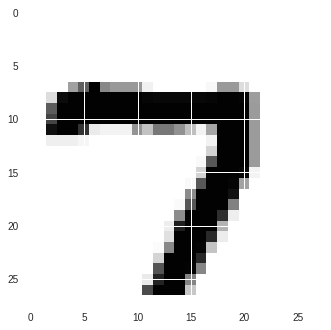

In [135]:
IMG=[]
for a in range(5):
  IMG.append(np.reshape(X_train_2[a][0],(28,28)))
  IMG.append(np.reshape(X_train_2[a][1],(28,28)))
plt.imshow(IMG[2])
#print(IMG[2])

## Entraînement GMV

In [172]:
def train_GMV(generator, discriminator, gan, X_train_2, epochs=100, batchSize=128):
  batchCount = int(nb_train_par_classe*10 / batchSize)
  print ('Epochs:', epochs)
  print ('Batch size:', batchSize)
  print ('Batches per epoch:', batchCount)
  d_losses = []
  g_losses = []
  d_moy_pos=[]
  d_moy_neg=[]
  Pictures=np.zeros((epochs,2,4,28,28))
  for e in range(1, epochs+1):
    if e%5==0:
      print("Regeneration de la base de donnees...")
      #creation des couples d'images
      for i in range(nb_train_par_classe):
        for j in range(10):
          k1=rd.randint(0,len(X[j])-1)
          k2=rd.randint(0,len(X[j])-1)
          while k1==k2:
            k2=rd.randint(0,len(X[j])-1)
          img1=X[j][k1]
          img2=X[j][k2]
          X_train_2[10*i+j][0]=img1
          X_train_2[10*i+j][1]=img2
  
      np.random.shuffle(X_train_2)
    
    
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    dloss=0
    gloss=0

    for _ in tqdm(range(batchCount)):
      # DISCRIMINATOR
      #generation des vecteurs de bruit
      vector_c = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      
      #passage dans le generateur
      generatedImages_1 = generator.predict([vector_c,vector_v1])
      generatedImages_2 = generator.predict([vector_c,vector_v2])
      
      #entraînement du discriminateur
      indices=np.random.randint(0, nb_train_par_classe*10, size=batchSize)
      imageBatch_1 = np.zeros((len(indices),28,28,1))
      imageBatch_2 = np.zeros((len(indices),28,28,1))
      for i in range(len(indices)):
        imageBatch_1[i]=X_train_2[indices[i]][0]
        imageBatch_2[i]=X_train_2[indices[i]][1]
      XDis1=np.concatenate((imageBatch_1,generatedImages_1))
      XDis2=np.concatenate((imageBatch_2,generatedImages_2))
      if nb_sorties==1:
        yDis = np.zeros(2*batchSize)
        yDis[:batchSize] = 0.9
        yDis[batchSize:] = 0.1
      elif nb_sorties==2:
        yDis = np.zeros((2*batchSize,2))
        yDis[:batchSize] = [1,0]
        yDis[batchSize:]=[0,1]
        
      #Recuperation des valeurs des predictions du discriminateur
      predictions=discriminator.predict([XDis1, XDis2])
      if nb_sorties==1:
        moy_pos=0
        moy_neg=0
        for z in range(len(predictions)):
          if z < batchSize:
            moy_pos +=predictions[z]
          else:
            moy_neg +=predictions[z]

        moy_pos=2*float(moy_pos)/len(predictions)
        moy_neg=2*float(moy_neg)/len(predictions)
      elif nb_sorties==2:
        moy_pos=[0,0]
        moy_neg=[0,0]
        for z in range(len(predictions)):
          if z < batchSize:
            moy_pos[0]+=predictions[z][0]
            moy_pos[1]+=predictions[z][1]
          else:
            moy_neg[0]+=predictions[z][0]
            moy_neg[1]+=predictions[z][1]

        moy_pos[0]=2*float(moy_pos[0])/len(predictions)
        moy_pos[1]=2*float(moy_pos[1])/len(predictions)
        moy_neg[0]=2*float(moy_neg[0])/len(predictions)
        moy_neg[1]=2*float(moy_neg[1])/len(predictions)
      d_moy_pos.append(moy_pos)
      d_moy_neg.append(moy_neg)
      
      dloss += discriminator.train_on_batch([XDis1,XDis2], yDis)

      # GENERATOR
      vector_c = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      if nb_sorties==1:
        yGen=np.zeros(batchSize)
        yGen[:]=0.9
      elif nb_sorties==2:
        yGen = np.zeros((batchSize,2))
        yGen[:]=[1,0]
      discriminator.trainable = False
      gloss += gan.train_on_batch([vector_c,vector_v1,vector_v2], yGen)
      
    # TESTS ET EVALUATIONS
    d_losses.append(dloss)
    g_losses.append(gloss)
    
    #Pour recuperer des images de l'epoch :
    vector_c = np.random.normal(0, 1, size=[4, randomVectorSize])
    vector_v1 = np.random.normal(0, 1, size=[4, randomVectorSize])
    vector_v2 = np.random.normal(0, 1, size=[4, randomVectorSize])
    Pictures[e-1][0] = np.reshape(generator.predict([vector_c,vector_v1]),(4,28,28))
    Pictures[e-1][1] = np.reshape(generator.predict([vector_c,vector_v2]),(4,28,28))
      
    print ("Losses : DISCRIMINATOR ", d_losses[-1]," GENERATOR ", g_losses[-1])
    
  #Sauvegarde des poids
  !rm generator_GMV.h5
  !rm discriminator_GMV.h5
  !rm gan_GMV.h5

  generator_GMV.save('generator_GMV.h5')
  discriminator_GMV.save('discriminator_GMV.h5')
  gan_GMV.save('gan_GMV.h5')
  return(d_losses,g_losses,Pictures,d_moy_pos,d_moy_neg)


d_losses,g_losses,Pictures,d_moy_pos,d_moy_neg=train_GMV(generator_GMV,discriminator_GMV,gan_GMV,X_train_2,20,128)    

  0%|          | 0/312 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  0%|          | 1/312 [00:00<00:42,  7.31it/s]

Epochs: 20
Batch size: 128
Batches per epoch: 312
--------------- Epoch 1 ---------------


  0%|          | 0/312 [00:00<?, ?it/s]

Losses : DISCRIMINATOR  42.97379416227341  GENERATOR  60.947535052895546
--------------- Epoch 2 ---------------


  0%|          | 0/312 [00:00<?, ?it/s]

Losses : DISCRIMINATOR  42.8854885995388  GENERATOR  61.8491303473711
--------------- Epoch 3 ---------------


  1%|          | 2/312 [00:00<00:30, 10.30it/s]

Losses : DISCRIMINATOR  42.3574443757534  GENERATOR  62.11738954484463
--------------- Epoch 4 ---------------


100%|██████████| 312/312 [00:30<00:00, 10.12it/s]


Losses : DISCRIMINATOR  42.13922184705734  GENERATOR  62.44452702999115
Regeneration de la base de donnees...


  1%|          | 2/312 [00:00<00:29, 10.41it/s]

--------------- Epoch 5 ---------------


  0%|          | 1/312 [00:00<00:36,  8.45it/s]

Losses : DISCRIMINATOR  42.129217967391014  GENERATOR  63.278528809547424
--------------- Epoch 6 ---------------


  0%|          | 0/312 [00:00<?, ?it/s]

Losses : DISCRIMINATOR  41.85905211418867  GENERATOR  63.35161176323891
--------------- Epoch 7 ---------------


  0%|          | 1/312 [00:00<00:31,  9.90it/s]

Losses : DISCRIMINATOR  41.637820079922676  GENERATOR  64.01853673160076
--------------- Epoch 8 ---------------


  0%|          | 1/312 [00:00<00:31,  9.72it/s]

Losses : DISCRIMINATOR  41.14678794890642  GENERATOR  64.4262588173151
--------------- Epoch 9 ---------------


100%|██████████| 312/312 [00:31<00:00,  9.79it/s]


Losses : DISCRIMINATOR  40.96759153902531  GENERATOR  65.16858030855656
Regeneration de la base de donnees...


  1%|          | 2/312 [00:00<00:30, 10.32it/s]

--------------- Epoch 10 ---------------


  0%|          | 1/312 [00:00<00:32,  9.57it/s]

Losses : DISCRIMINATOR  41.08924514055252  GENERATOR  64.89469255506992
--------------- Epoch 11 ---------------


  0%|          | 0/312 [00:00<?, ?it/s]

Losses : DISCRIMINATOR  40.80472960323095  GENERATOR  65.62600420415401
--------------- Epoch 12 ---------------


  0%|          | 1/312 [00:00<00:33,  9.30it/s]

Losses : DISCRIMINATOR  40.72621615976095  GENERATOR  66.14448012411594
--------------- Epoch 13 ---------------


  0%|          | 0/312 [00:00<?, ?it/s]

Losses : DISCRIMINATOR  40.283456787467  GENERATOR  66.5617986023426
--------------- Epoch 14 ---------------


100%|██████████| 312/312 [00:32<00:00,  9.70it/s]


Losses : DISCRIMINATOR  40.14468966424465  GENERATOR  66.63477146625519
Regeneration de la base de donnees...


  0%|          | 1/312 [00:00<00:31,  9.77it/s]

--------------- Epoch 15 ---------------


  0%|          | 1/312 [00:00<00:38,  8.17it/s]

Losses : DISCRIMINATOR  40.07181178033352  GENERATOR  67.07821148633957
--------------- Epoch 16 ---------------


  0%|          | 1/312 [00:00<00:31,  9.99it/s]

Losses : DISCRIMINATOR  39.918653815984726  GENERATOR  67.54342019557953
--------------- Epoch 17 ---------------


  0%|          | 0/312 [00:00<?, ?it/s]

Losses : DISCRIMINATOR  39.76716261357069  GENERATOR  67.94767190515995
--------------- Epoch 18 ---------------


  0%|          | 0/312 [00:00<?, ?it/s]

Losses : DISCRIMINATOR  39.43395583331585  GENERATOR  68.40378466248512
--------------- Epoch 19 ---------------


100%|██████████| 312/312 [00:31<00:00,  9.80it/s]


Losses : DISCRIMINATOR  39.31134070456028  GENERATOR  69.19560776650906
Regeneration de la base de donnees...


  0%|          | 1/312 [00:00<00:32,  9.55it/s]

--------------- Epoch 20 ---------------


100%|██████████| 312/312 [00:32<00:00,  9.71it/s]


Losses : DISCRIMINATOR  39.52206774801016  GENERATOR  69.33001412451267


### Sauvegarde

In [0]:
#Identification du Drive

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Sauvegarde des poids

!rm generator_GMV.h5
!rm discriminator_GMV.h5
!rm gan_GMV.h5

generator_GMV.save('generator_GMV.h5')
discriminator_GMV.save('discriminator_GMV.h5')
gan_GMV.save('gan_GMV.h5')

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'generator_GMV.h5'})
uploaded.SetContentFile('generator_GMV.h5')
uploaded.Upload()
uploaded = drive.CreateFile({'title': 'discriminator_GMV.h5'})
uploaded.SetContentFile('discriminator_GMV.h5')
uploaded.Upload()
uploaded = drive.CreateFile({'title': 'gan_GMV.h5'})
uploaded.SetContentFile('gan_GMV.h5')
uploaded.Upload()
#print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [21]:
!ls

datalab  discriminator_GMV.h5  gan_GMV.h5  generator_GMV.h5


In [0]:
#Telechargement des poids depuis le Drive

!rm generator_GMV.h5
!rm discriminator_GMV.h5
!rm gan_GMV.h5

file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for f in file_list:
  #print('title: %s, id: %s' % (f['title'], f['id']))
  if f['title']=='generator_GMV.h5':
    IDgen=f['id']
  elif f['title']=='discriminator_GMV.h5':
    IDdis=f['id']
  elif f['title']=='gan_GMV.h5':
    IDgan=f['id']

downloaded = drive.CreateFile({'id': IDgen})
downloaded.GetContentFile('generator_GMV.h5') 
downloaded = drive.CreateFile({'id': IDdis})
downloaded.GetContentFile('discriminator_GMV.h5')
downloaded = drive.CreateFile({'id': IDgan})
downloaded.GetContentFile('gan_GMV.h5')

from keras.models import load_model
generator_GMV = load_model('generator_GMV.h5')
discriminator_GMV = load_model('discriminator_GMV.h5')
gan_GMV = load_model('gan_GMV.h5')


### Graphiques

In [60]:
#Diminuer le learning rate du discriminateur :

lr = K.get_value(discriminator_GMV.optimizer.lr)
K.set_value(discriminator_GMV.optimizer.lr, lr*0.9)
print("lr changed to {}".format(lr*0.9))

lr changed to 8.999999772640876e-05


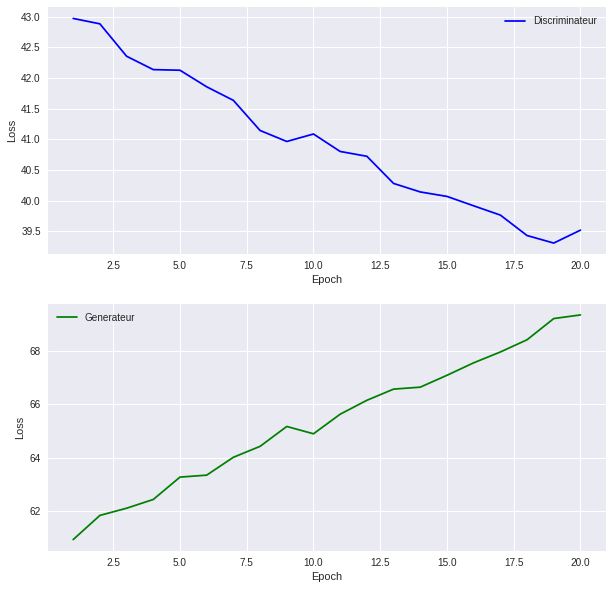

In [173]:
A=np.linspace(1,len(d_losses),len(d_losses))
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(A,d_losses,color='blue',label="Discriminateur")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(2,1,2)
plt.plot(A,g_losses, color='green',label="Generateur")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

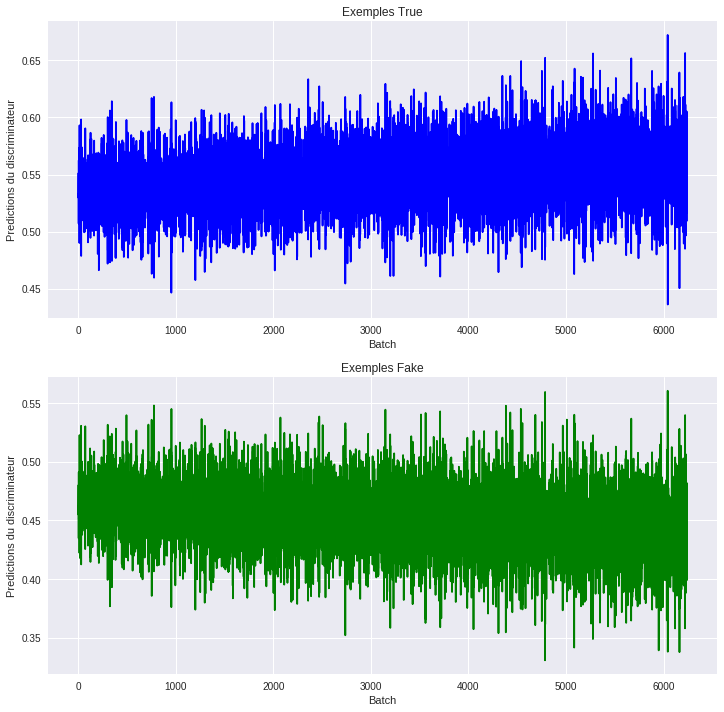

In [174]:
#Affiche les valeurs moyennes des predictions du discriminateur
A=np.linspace(1,len(d_moy_pos),len(d_moy_pos))
plt.figure(figsize=(12,12))

if nb_sorties==1:
  Vrai=[]
  Fake=[]
  for i in range(len(d_moy_pos)):
    Vrai.append(d_moy_pos[i])
    Fake.append(d_moy_neg[i])
  
  plt.subplot(2,1,1)
  plt.plot(A,Vrai,color='blue')
  plt.ylabel("Predictions du discriminateur")
  plt.xlabel("Batch")
  plt.title("Exemples True")
  plt.subplot(2,1,2)
  plt.plot(A,Fake,color='green')
  plt.ylabel("Predictions du discriminateur")
  plt.xlabel("Batch")
  plt.title("Exemples Fake")
  plt.show()
  
  
elif nb_sorties==2:
  True_0=[]
  True_1=[]
  Fake_0=[]
  Fake_1=[]
  for i in range(len(d_moy_pos)):
    True_0.append(d_moy_pos[i][0])
    True_1.append(d_moy_pos[i][1])
    Fake_0.append(d_moy_neg[i][0])
    Fake_1.append(d_moy_neg[i][1])
  
  plt.subplot(2,1,1)
  plt.plot(A,True_0,color='blue',label="1ere valeur")
  plt.plot(A,True_1,color='green',label="2eme valeur")
  plt.ylabel("Predictions du discriminateur")
  plt.xlabel("Batch")
  plt.title("Exemples True")
  plt.legend()
  plt.subplot(2,1,2)
  plt.plot(A,Fake_0,color='blue',label="1ere valeur")
  plt.plot(A,Fake_1,color='green',label="2eme valeur")
  plt.ylabel("Predictions du discriminateur")
  plt.xlabel("Batch")
  plt.title("Exemples Fake")
  plt.legend()
  plt.show()

(20, 2, 4, 28, 28)
Images generees toutes les 10 epochs : 


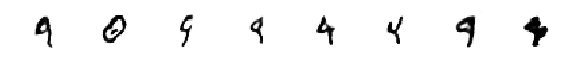

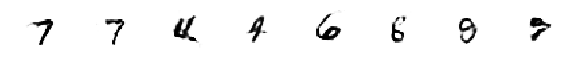

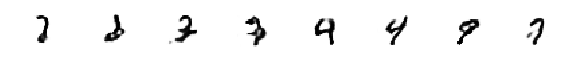

In [175]:
#Affiche des images generees pour les epochs %10
print(Pictures.shape)
nbe=Pictures.shape[0]
nbi=Pictures.shape[2]
print("Images generees toutes les 10 epochs : ")
for e in range(nbe//10+1):
  for i in range(nbi):
    plt.subplot(nbe//10+1, 2*nbi, 2*nbi*e+2*i+1)
    plt.imshow(Pictures[e][0][i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
    plt.subplot(nbe//10+1, 2*nbi, 2*nbi*e+2*i+2)
    plt.imshow(Pictures[e][1][i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

## Entraînement CGMV

In [0]:
def train_CGMV(generator, discriminator, gan, X_train, epochs=10, batchSize=128):
  batchCount = int(nb_train_par_classe*10 / batchSize)
  print ('Epochs:', epochs)
  print ('Batch size:', batchSize)
  print ('Batches per epoch:', batchCount)
  d_losses = []
  g_losses = []
  for e in range(1, epochs+1):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    dloss=0
    gloss=0
    for _ in tqdm(range(batchCount)):
      # DISCRIMINATOR
      #generation des vecteurs de bruit
      vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v3 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      
      #choix des images
      img_x1=np.zeros((batchSize,28,28,1))
      img_x2=np.zeros((batchSize,28,28,1))
      for k in range(batchSize):
        indice1=rd.randint(0,len(X_train_2)-1)
        indice2=rd.randint(0,len(X_train_2)-1)
        img_x1[k]=X_train_2[indice1][0]
        img_x2[k]=X_train_2[indice2][0]
        
      #passage dans l'encodeur
      vector_c1=encodeur.predict(img_x1)
      vector_c2=encodeur.predict(img_x2)
      
      #passage dans le generateur
      generatedImages_1 = generator.predict([vector_c1,vector_v1])
      generatedImages_2 = generator.predict([vector_c1,vector_v2])
      generatedImages_3 = generator.predict([vector_c2,vector_v3])
      
      #entraînement du discriminateur
      indices=np.random.randint(0, len(X_train_2), size=batchSize)
      imageBatch_1 = np.zeros((batchSize,28,28,1))
      imageBatch_2 = np.zeros((batchSize,28,28,1))
      for i in range(len(indices)):
        imageBatch_1[i]=X_train_2[indices[i]][0]
        imageBatch_2[i]=X_train_2[indices[i]][1]
      XDis1=np.concatenate((imageBatch_1,generatedImages_1,img_x2))
      XDis2=np.concatenate((imageBatch_2,generatedImages_2,generatedImages_3))
      yDis = np.zeros(3*batchSize)
      yDis[:batchSize] = 0.9
      dloss += discriminator.train_on_batch([XDis1,XDis2], yDis)

      # GENERATOR
      vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v3 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      
      #choix des images
      img_x1=np.zeros((batchSize,28,28,1))
      img_x2=np.zeros((batchSize,28,28,1))
      for k in range(batchSize):
        indice1=rd.randint(0,len(X_train_2)-1)
        indice2=rd.randint(0,len(X_train_2)-1)
        img_x1[k]=X_train_2[indice1][0]
        img_x2[k]=X_train_2[indice2][0]

      yGen1 = np.ones(batchSize)
      yGen2 = np.ones(batchSize)
      discriminator.trainable = False
      gloss += gan.train_on_batch([img_x1,img_x2,vector_v1,vector_v2,vector_v3], [yGen1,yGen2])
      
    # TESTS ET EVALUATIONS
    d_losses.append(dloss)
    g_losses.append(gloss)
    print ("Losses : DISCRIMINATOR ", d_losses[-1]," GENERATOR ", g_losses[-1])
  return(d_losses,g_losses)


d_losses_C,g_losses_C=train_GAN_CGMV(generator_CGMV,discriminator_CGMV,gan_CGMV,X_train_2,10,128)

In [0]:
A=np.linspace(0,len(d_losses_C),len(d_losses_C))
plt.plot(A,d_losses_C,color='blue',label="Discriminateur")
plt.plot(A,g_losses_C, color='green',label="Generateur")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Tests

## Fonctions

In [0]:
#Affichage de 10 couples d'images generees

def plotGeneratedImages_GMV(generator, examples=10, figsize=(15, 15)):
  vector_c = np.random.normal(0, 1, size=[examples,randomVectorSize])
  vector_v1 = np.random.normal(0, 1, size=[examples,randomVectorSize])
  vector_v2 = np.random.normal(0, 1, size=[examples,randomVectorSize])
  
  generatedImages_1 = generator.predict([vector_c,vector_v1]).reshape(examples, 28, 28)
  generatedImages_2 = generator.predict([vector_c,vector_v2]).reshape(examples, 28, 28)

  print("Couples d'images generees par le GMV :")
  dim=[examples, 2]
  plt.figure(figsize=figsize)
  for i in range(examples):
      plt.subplot(dim[0], dim[1], 2*i+1)
      plt.imshow(generatedImages_1[i], interpolation='nearest', cmap='gray_r')
      plt.axis('off')
      plt.subplot(dim[0], dim[1], 2*i+2)
      plt.imshow(generatedImages_2[i], interpolation='nearest', cmap='gray_r')
      plt.axis('off')
  plt.tight_layout()
  plt.show()
  #plt.savefig('gan_generated_image.png')
  
def plotGeneratedImages_CGMV(generator, examples=10, dim=(10, 3), figsize=(15, 15)):
  vector_v1 = np.random.normal(0, 1, size=[examples,randomVectorSize])
  vector_v2 = np.random.normal(0, 1, size=[examples,randomVectorSize])
  
  #choix des images
  img_x1=np.zeros((examples,28,28,1))
  for k in range(batchSize):
    indice1=rd.randint(0,len(X_train_2)-1)
    img_x1[k]=X_train_2[indice1][0]

  #passage dans l'encodeur
  vector_c1=encodeur.predict(img_x1)

  #passage dans le generateur
  generatedImages_1 = generator.predict([vector_c1,vector_v1]).reshape(examples, 28, 28)
  generatedImages_2 = generator.predict([vector_c1,vector_v2]).reshape(examples, 28, 28)
  
  print("image d'origine - image generee 1 - image generee 2")
  plt.figure(figsize=figsize)
  for i in range(examples):
      plt.subplot(dim[0], dim[1], 3*i+1)
      plt.imshow(img_x1[i], interpolation='nearest', cmap='gray_r')
      plt.axis('off')
      plt.subplot(dim[0], dim[1], 3*i+2)
      plt.imshow(generatedImages_1[i], interpolation='nearest', cmap='gray_r')
      plt.axis('off')
      plt.subplot(dim[0], dim[1], 3*i+3)
      plt.imshow(generatedImages_2[i], interpolation='nearest', cmap='gray_r')
      plt.axis('off')
  plt.tight_layout()
  plt.show()
  #plt.savefig('gan_generated_image.png')

In [0]:
def tableau_GMV(generator, examples=10, figsize=(10,10)):
  vector_c = np.random.normal(0, 1, size=[examples,randomVectorSize])
  vector_v = np.random.normal(0, 1, size=[examples,randomVectorSize])
  dim=[examples, examples]
  plt.figure(figsize=figsize)
  for i in range(examples):
    C=np.zeros((examples,randomVectorSize))
    C[:]=vector_c[i]
    generatedImages=generator.predict([C,vector_v]).reshape(examples,28,28)
    for j in range(examples):
      plt.subplot(dim[0], dim[1], 10*i+j+1)
      plt.imshow(generatedImages[j], interpolation='nearest', cmap='gray_r')
      plt.axis('off')
  plt.tight_layout()
  plt.show()

In [0]:
#Test de l'accuracy du discriminateur et du generateur

def test_GMV(gan, discriminator, generator, seuil=0.45, batchSize=100):
  #generation des vecteurs de bruit
  vector_c = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
  vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
  vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
  
  #passage dans le generateur
  generatedImages_1 = generator.predict([vector_c,vector_v1])
  generatedImages_2 = generator.predict([vector_c,vector_v2])

  #test du discriminateur
  indices=np.random.randint(0, nb_test_par_classe*10, size=batchSize)
  imageBatch_1 = np.zeros((len(indices),28,28,1))
  imageBatch_2 = np.zeros((len(indices),28,28,1))
  for i in range(len(indices)):
    imageBatch_1[i]=X_test_2[indices[i]][0]
    imageBatch_2[i]=X_test_2[indices[i]][1]
  XDis1=np.concatenate((imageBatch_1,generatedImages_1))
  XDis2=np.concatenate((imageBatch_2,generatedImages_2))
  predictions = discriminator.predict([XDis1,XDis2])
  score_d=0
  if nb_sorties==1:
    for j in range(len(predictions)):
      if j<batchSize and predictions[j]>seuil:
        score_d+=1
      elif j>= batchSize and predictions[j]<seuil:
        score_d+=1
  elif nb_sorties==2:
    for j in range(len(predictions)):
      if j<batchSize and np.argmax(predictions[j])==0:
        score_d+=1
      elif j>= batchSize and np.argmax(predictions[j])==1:
        score_d+=1
  score_d=float(score_d)/len(predictions)
  print("Seuil = ",seuil)
  print("Score du discriminateur : "+str(score_d*100)+"%")
  
  #test du generateur
  predictions_g = gan.predict([vector_c,vector_v1,vector_v2])
  score_g=0
  #print(predictions_g)
  if nb_sorties==1:
    for j in range(len(predictions_g)):
      if predictions_g[j]>seuil:
        score_g+=1
  elif nb_sorties==2:
    for j in range(len(predictions_g)):
      if np.argmax(predictions_g[j])==0:
        score_g+=1
  score_g=float(score_g)/len(predictions_g)
  print("Score du generateur : "+str(score_g*100)+"%")
  
  #Affichage d'exemples
  plt.figure(figsize=(10,10))
  for i in range(4):
      plt.subplot(8, 2, 2*i+1)
      plt.imshow(np.reshape(generatedImages_1[i],(28,28)), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
      plt.subplot(8, 2, 2*i+2)
      plt.imshow(np.reshape(generatedImages_2[i],(28,28)), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
  for i in range(4):
      plt.subplot(8, 2, 2*i+9)
      plt.imshow(np.reshape(imageBatch_1[i],(28,28)), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
      plt.subplot(8, 2, 2*i+10)
      plt.imshow(np.reshape(imageBatch_2[i],(28,28)), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
  plt.tight_layout()
  plt.show()
  print("Predictions pour les images generees : ",predictions[batchSize:batchSize+4])
  print("Predictions pour les images de MNIST : ",predictions[:4])

  
def test_CGMV(gan, discriminator, generator, seuil=0.45, batchSize=100):
  #generation des vecteurs de bruit
  vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
  vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
  vector_v3 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
  
  #choix des images
  img_x1=np.zeros((batchSize,28,28,1))
  img_x2=np.zeros((batchSize,28,28,1))
  for k in range(batchSize):
    indice1=rd.randint(0,len(X_train_2)-1)
    indice2=rd.randint(0,len(X_train_2)-1)
    img_x1[k]=X_train_2[indice1][0]
    img_x2[k]=X_train_2[indice2][0]

  #passage dans l'encodeur
  vector_c1=encodeur.predict(img_x1)
  vector_c2=encodeur.predict(img_x2)

  #passage dans le generateur
  generatedImages_1 = generator.predict([vector_c1,vector_v1])
  generatedImages_2 = generator.predict([vector_c1,vector_v2])
  generatedImages_3 = generator.predict([vector_c2,vector_v3])

  #test du discriminateur
  indices=np.random.randint(0, len(X_train_2), size=batchSize)
  imageBatch_1 = np.zeros((batchSize,28,28,1))
  imageBatch_2 = np.zeros((batchSize,28,28,1))
  for i in range(len(indices)):
    imageBatch_1[i]=X_train_2[indices[i]][0]
    imageBatch_2[i]=X_train_2[indices[i]][1]
  XDis1=np.concatenate((imageBatch_1,generatedImages_1,img_x2))
  XDis2=np.concatenate((imageBatch_2,generatedImages_2,generatedImages_3))
  predictions = discriminator.predict([XDis1,XDis2])
  score_d=0
  for j in range(len(predictions)):
    if j<batchSize and predictions[j]>seuil:
      score_d+=1
    elif j>= batchSize and predictions[j]<seuil:
      score_d+=1
  score_d=float(score_d)/len(predictions)
  print("Seuil = ",seuil)
  print("Score du discriminateur : "+str(score_d*100)+"%")
  
  #test du generateur
  predictions_g = gan.predict([img_x1,img_x2,vector_v1,vector_v2,vector_v3])
  score_g=0
  #print(predictions_g)
  for j in range(len(predictions_g)):
    if predictions_g[j][0]>seuil:
      score_g+=1
    if predictions_g[j][1]>seuil:
      score_g+=1
  score_g=float(score_g)/(2*len(predictions_g))
  print("Score du generateur : "+str(score_g*100)+"%")
  
  #Affichage d'exemples
  plt.figure(figsize=(10,10))
  for i in range(4):
      plt.subplot(8, 2, 2*i+1)
      plt.imshow(np.reshape(generatedImages_1[i],(28,28)), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
      plt.subplot(8, 2, 2*i+2)
      plt.imshow(np.reshape(generatedImages_2[i],(28,28)), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
  for i in range(4):
      plt.subplot(8, 2, 2*i+9)
      plt.imshow(np.reshape(imageBatch_1[i],(28,28)), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
      plt.subplot(8, 2, 2*i+10)
      plt.imshow(np.reshape(imageBatch_2[i],(28,28)), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
  plt.tight_layout()
  plt.show()
  print("Predictions pour les images generees : ",predictions[batchSize:batchSize+4])
  print("Predictions pour les images de MNIST : ",predictions[:4])
  

## Tests GMV

Couples d'images generees par le GMV :


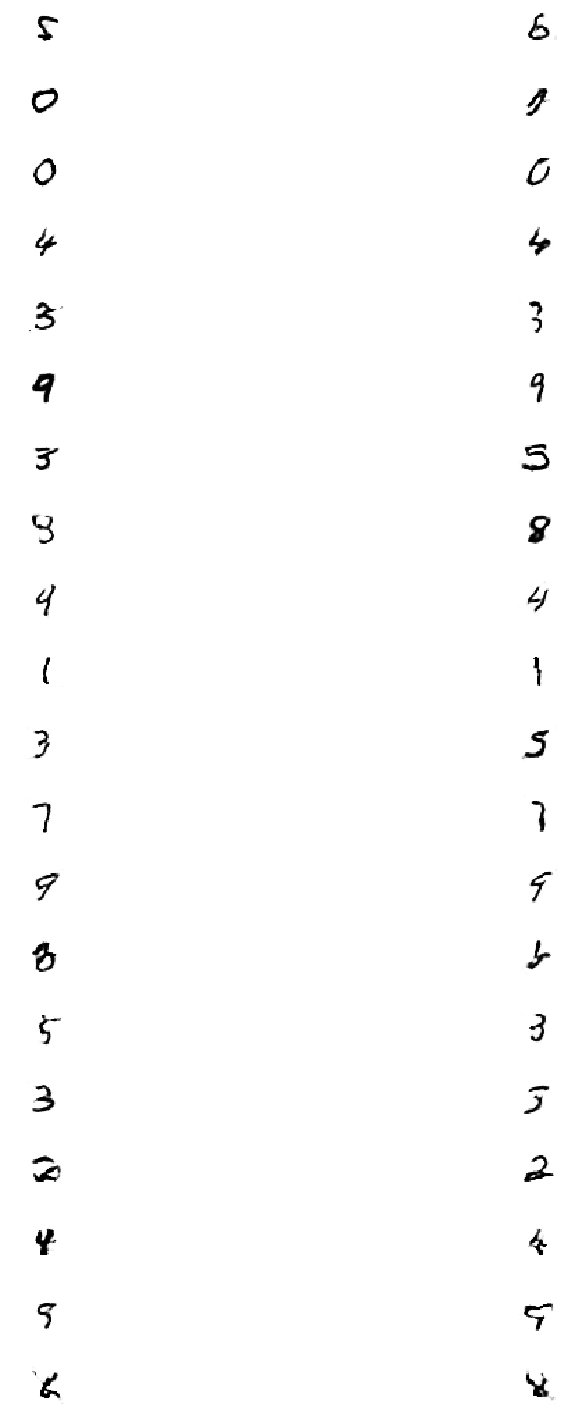

In [176]:
plotGeneratedImages_GMV(generator_GMV,examples=20, figsize=(20,20)) #Affichage de 10 couples d'images generees

Seuil =  50
Score du discriminateur : 50.0%
Score du generateur : 0.0%


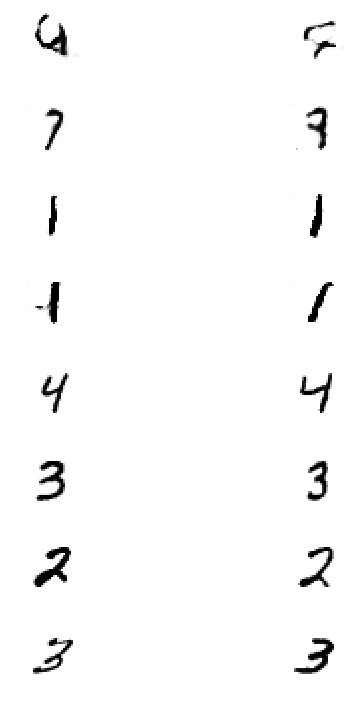

Predictions pour les images generees :  [[0.36153916]
 [0.26654026]
 [0.3746067 ]
 [0.42302558]]
Predictions pour les images de MNIST :  [[0.44320518]
 [0.52982384]
 [0.6444564 ]
 [0.32602885]]


In [177]:
test_GMV(gan_GMV, discriminator_GMV, generator_GMV, seuil=50) # Calcul de l'accuracy du generateur et du discriminateur

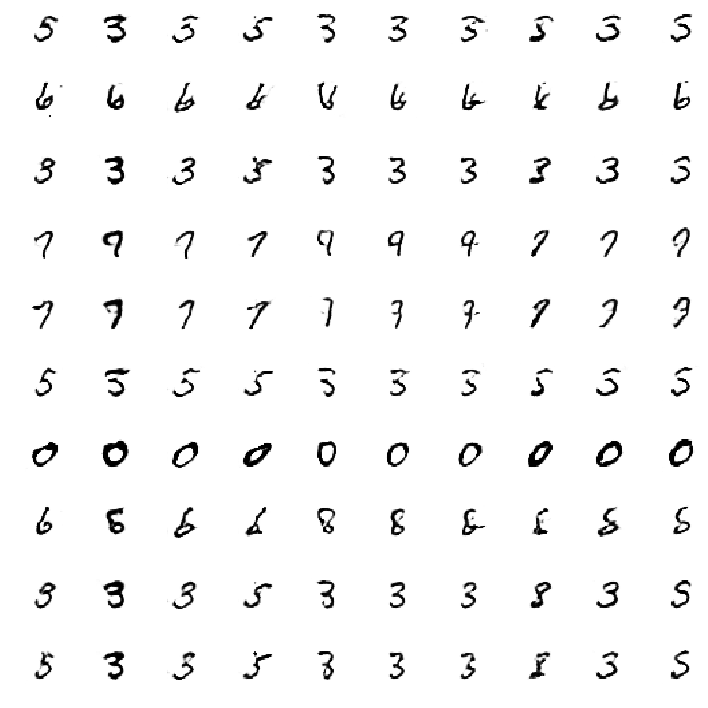

In [181]:
tableau_GMV(generator_GMV)

## Tests CGMV

In [0]:
plotGeneratedImages_CGMV(generator_CGMV) #Affichage de 10 couples d'images generees

In [0]:
test_CGMV(gan_CGMV, discriminator_CGMV, generator_CGMV) # Calcul de l'accuracy du generateur et du discriminateur